In [37]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [45]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

NDVI_df = pd.read_csv(NDVI_PATH)
NDVI_df = NDVI_df.rename(columns={"date": "Data", "ndvi": "NDVI"})
NDVI_df["Year"] = pd.to_datetime(NDVI_df["Data"]).dt.year
NDVI_df.to_csv(
    "../data/PROCESSED/ndvi.csv",
    index=False,
)

PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]



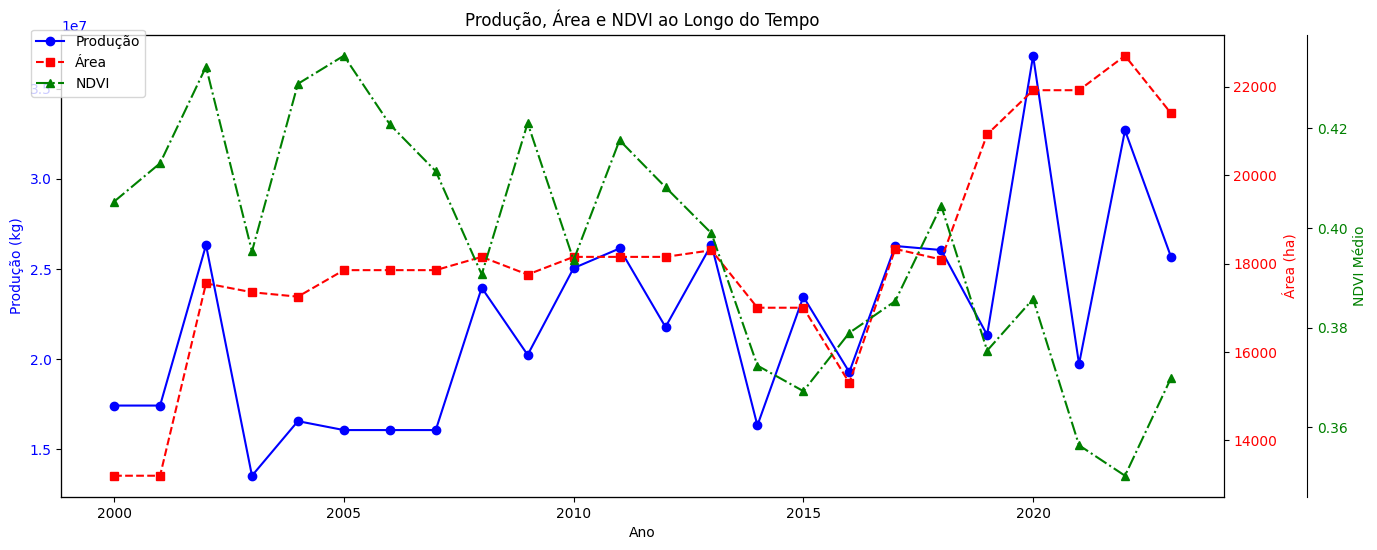

In [39]:
ndvi_anual = NDVI_df.groupby('Year')['NDVI'].mean().reset_index()
ndvi_anual.columns = ['Year', 'NDVI_mean']

df_completo = PROD.merge(ndvi_anual, on='Year', how='inner')

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(df_completo['Year'], df_completo['Production (kg)'], color='blue', marker='o', label='Produção')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Produção (kg)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_completo['Year'], df_completo['Area (ha)'], color='red', marker='s', linestyle='--', label='Área')
ax2.set_ylabel('Área (ha)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df_completo['Year'], df_completo['NDVI_mean'], color='green', marker='^', linestyle='-.', label='NDVI')
ax3.set_ylabel('NDVI Médio', color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Produção, Área e NDVI ao Longo do Tempo')
plt.show()

### Produção, Área e NDVI ao Longo do Tempo
  - Produção (kg): Aumentou de 1.5M kg (2000) para 3.0M kg (2020), indicando crescimento constante.
  - Área (ha): Expansão de 14,000 ha (2000) para 22,000 ha (2020), mostrando estratégia extensiva.
  - NDVI Médio: Manteve-se estável (~0.36), sem correlação clara com a produção.

Insights:
  - O crescimento da produção está diretamente ligado à expansão da área, não a melhorias na fertilidade (NDVI).
  - NDVI constante sugere que novas áreas cultivadas têm fertilidade similar às existentes.

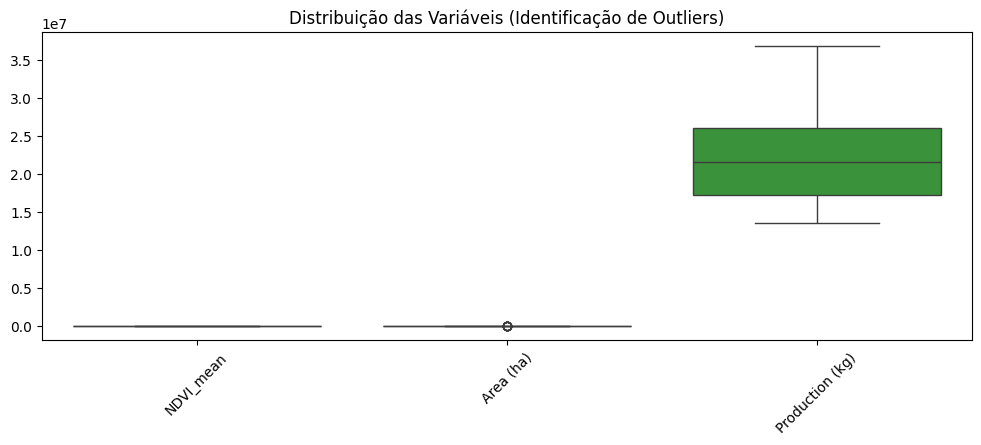

In [40]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_completo[['NDVI_mean', 'Area (ha)', 'Production (kg)']])
plt.title('Distribuição das Variáveis (Identificação de Outliers)')
plt.xticks(rotation=45)
plt.show()

### Distribuição das Variáveis (Identificação de Outliers)
  - Área (ha): Distribuição assimétrica, com outliers acima de 20,000 ha (expansão extrema).
  - Produção (kg): Concentrada entre 1.5M kg e 3.0M kg, com poucos valores extremos.
  - NDVI: Valores estreitos (0.36–0.42), indicando pouca variação na fertilidade.

Insights:
  - Outliers em Área sugerem anos com expansão territorial atípica (ex.: políticas agrícolas).
  - Baixa variabilidade do NDVI limita sua utilidade como preditor.

In [41]:
print("Dados faltantes por variável:")
print(df_completo[['Year', 'NDVI_mean', 'Area (ha)', 'Production (kg)']].isnull().sum())

Dados faltantes por variável:
Year               0
NDVI_mean          0
Area (ha)          0
Production (kg)    0
dtype: int64


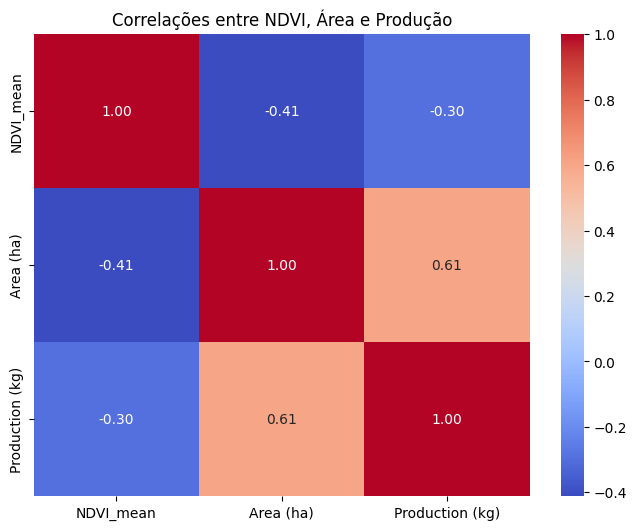

In [42]:
correlacoes = df_completo[['NDVI_mean', 'Area (ha)', 'Production (kg)']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlações entre NDVI, Área e Produção')
plt.show()

### Correlações entre NDVI, Área e Produção
  - NDVI × Produção: Correlação negativa (-0.30), contradizendo expectativas.
  - Área × Produção: Correlação positiva forte (0.84), confirmando dependência da expansão.
  - NDVI × Área: Correlação negativa (-0.41), indicando que áreas maiores têm NDVI mais baixo.

Insights:
  - A correlação negativa NDVI-Produção pode indicar expansão para terras menos férteis.
  - A forte relação Área-Produção reforça a estratégia extensiva.

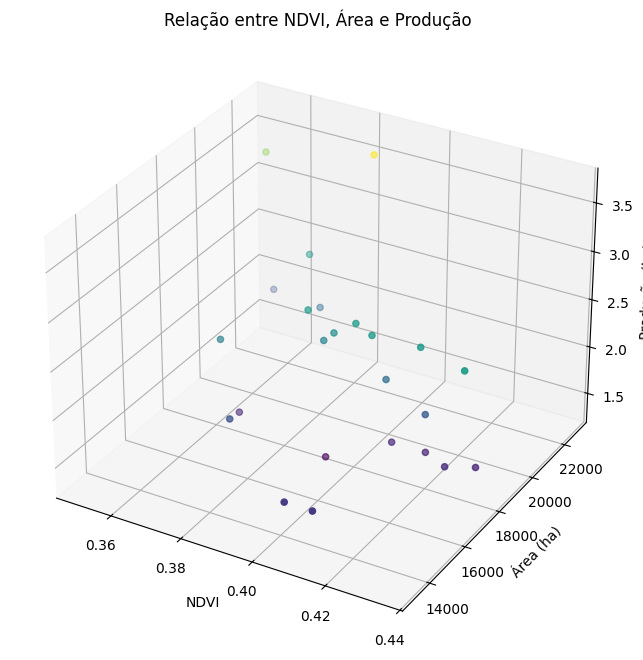

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_completo['NDVI_mean'],
    df_completo['Area (ha)'],
    df_completo['Production (kg)'],
    c=df_completo['Production (kg)'],
    cmap='viridis'
)
ax.set_xlabel('NDVI')
ax.set_ylabel('Área (ha)')
ax.set_zlabel('Produção (kg)')
plt.title('Relação entre NDVI, Área e Produção')
plt.show()

### Relação entre NDVI, Área e Produção
  - Áreas grandes (20,000+ ha): Associadas a NDVI baixo (~0.36) e produção alta (~3.0M kg).
  - Áreas médias (16,000–18,000 ha): NDVI mais alto (~0.40), mas produção menor (~2.0M kg).

Insights:
  - Produção elevada em áreas grandes com NDVI baixo sugere diminuição da eficiência por hectare.
  - Áreas menores com NDVI alto não são priorizadas, indicando foco em quantidade sobre qualidade.

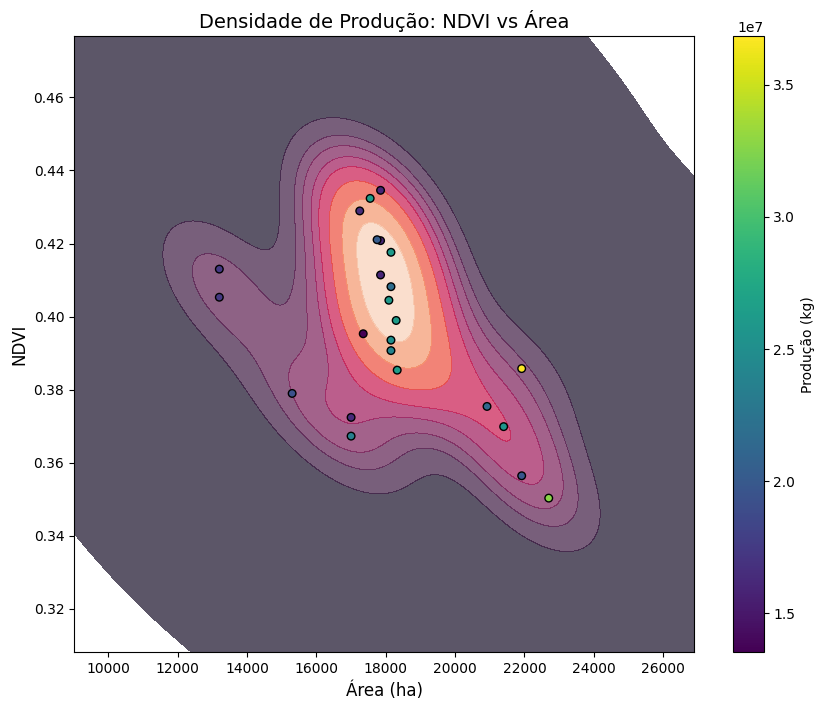

In [44]:
plt.figure(figsize=(10, 8))
contour = sns.kdeplot(
    x=df_completo['Area (ha)'], 
    y=df_completo['NDVI_mean'], 
    fill=True, 
    thresh=0,
    levels=10,
    cmap='rocket',
    alpha=0.7
)
plt.scatter(
    x=df_completo['Area (ha)'], 
    y=df_completo['NDVI_mean'], 
    c=df_completo['Production (kg)'],
    s=30,
    cmap='viridis',
    edgecolor='black'
)
plt.colorbar(label='Produção (kg)')
plt.title('Densidade de Produção: NDVI vs Área', fontsize=14)
plt.xlabel('Área (ha)', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.show()

### Densidade de Produção: NDVI vs Área
  - Maior densidade de produção: Concentrada em NDVI 0.38–0.40 e Área 16,000–18,000 ha.
  - Baixa densidade: NDVI < 0.36 (áreas degradadas) ou Área > 20,000 ha (superexpansão).

Insights:
  - Combinação ideal: NDVI médio (~0.39) e Área moderada (~17,000 ha).
  - Expansão além de 20,000 ha pode levar a degradação ambiental sem ganhos proporcionais.